In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torchvision import transforms
from torch.utils.data import Dataset

#plot
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np 
import torchmetrics as tm


In [2]:
import numpy as np
import dill as pickle

import torch

def read_res_from_dill(path):  
    with open(path, 'rb') as fp:
        res = pickle.load(fp)   
    return res

IGNORE_INDEX = -100
def calculate_mean_softmax_probs (softmax_probs_ensemble: torch.Tensor) -> torch.Tensor:

    mean_softmax_probs = torch.mean(softmax_probs_ensemble, dim=0)
    return mean_softmax_probs


def calculate_accuracy_over_ens(
    softmax_probs_ensemble: torch.Tensor, 
    final_targets: torch.Tensor
) -> float:
    """
    Calculate overall accuracy of the ensemble.

    Args:
        softmax_probs_ensemble (torch.Tensor): Mean softmax probabilities across the ensemble.
        final_targets (torch.Tensor): Target labels.

    Returns:
        float: Accuracy of the ensemble.
    """
    mean_softmax_probs = calculate_mean_softmax_probs(softmax_probs_ensemble)
    predicted_labels = torch.argmax(mean_softmax_probs, dim=-1)
    correct_predictions = torch.sum(predicted_labels == final_targets)
    accuracy = correct_predictions.item() / len(final_targets)

    return accuracy

def calculate_generative_loss_ens(
    ens_softmax_probs: torch.Tensor, 
    ens_targets: torch.Tensor, 
    epsilon: float = 1e-9
) -> torch.Tensor:
    """
    Calculate generative loss for the ensemble, focusing on specific classes.

    Args:
        ens_softmax_probs (torch.Tensor): Ensemble softmax probabilities.
        ens_targets (torch.Tensor): Ensemble targets.
        epsilon (float): Small value to prevent log(0). Default is 1e-6.

    Returns:
        torch.Tensor: Calculated loss.
    """

    # Calculate the mean softmax probabilities for the relevant classes
    mean_softmax_probs = calculate_mean_softmax_probs(ens_softmax_probs)

    # Log probabilities
    log_probs = torch.log(mean_softmax_probs + epsilon)

    # Calculate loss
    loss = F.nll_loss(log_probs, ens_targets, reduction='mean', ignore_index=IGNORE_INDEX)
    return loss.item()

def calculate_ce_over_ens(
    ens_softmax_probs: torch.Tensor, 
    ens_targets: torch.Tensor
) -> torch.Tensor:
    """
    Calculate calibration error over ensemble softmax probabilities.

    Args:
        ens_softmax_probs (torch.Tensor): Ensemble softmax probabilities.
        ens_targets (torch.Tensor): Targets for the ensemble.

    Returns:
        torch.Tensor: Calibration error.
    """
    mean_softmax_probs = calculate_mean_softmax_probs(ens_softmax_probs)
    num_classes = mean_softmax_probs.shape[-1]

    return tm.functional.classification.calibration_error(
        mean_softmax_probs,
        ens_targets,
        n_bins=10,
        num_classes=num_classes,
        task="multiclass",
    ).item()


In [6]:
def calculate_roc_auc_score(
    y_true: torch.Tensor, 
    y_scores: torch.Tensor
) -> float:
    """
    Calculate the ROC AUC score.

    Args:
        y_true (torch.Tensor): Ground truth binary labels.
        y_scores (torch.Tensor): Predicted scores.

    Returns:
        float: ROC AUC score.
    """
    y_true = torch.tensor(y_true, dtype=torch.bool)
    y_scores = torch.tensor(y_scores, dtype=torch.float32)

    desc_score_indices = torch.argsort(y_scores, descending=True)
    y_true = y_true[desc_score_indices]
    y_scores = y_scores[desc_score_indices]

    n_positives = torch.sum(y_true)
    n_negatives = y_true.size(0) - n_positives

    tpr = torch.cumsum(y_true, dim=0) / n_positives
    fpr = torch.cumsum(~y_true, dim=0) / n_negatives

    tpr = torch.cat([torch.zeros(1), tpr])
    fpr = torch.cat([torch.zeros(1), fpr])

    auroc = torch.trapz(tpr, fpr)

    return auroc.item()

def calculate_ood_performance_auroc(
    in_domain_scores: torch.Tensor, 
    out_domain_scores: torch.Tensor
) -> float:
    """
    Calculate OOD performance using AUROC score.

    Args:
        in_domain_scores (torch.Tensor): Scores for in-domain samples.
        out_domain_scores (torch.Tensor): Scores for out-of-domain samples.

    Returns:
        float: AUROC score representing OOD performance.
    """
    labels_in_domain = torch.zeros_like(in_domain_scores)
    labels_out_domain = torch.ones_like(out_domain_scores)

    all_scores = torch.cat([in_domain_scores, out_domain_scores])
    all_labels = torch.cat([labels_in_domain, labels_out_domain])

    all_scores = all_scores.cpu()
    all_labels = all_labels.cpu()

    auroc_score = calculate_roc_auc_score(all_labels, all_scores)

    return auroc_score

def calculate_max_average_probs(
    softmax_probs_ensemble: torch.Tensor
) -> torch.Tensor:
    """
    Calculate the maximum of average probabilities from ensemble softmax probabilities.

    Args:
        softmax_probs_ensemble (torch.Tensor): Ensemble softmax probabilities.

    Returns:
        torch.Tensor: Maximum of average probabilities.
    """
    mean_softmax_probs = calculate_mean_softmax_probs(softmax_probs_ensemble)
    max_mean_softmax_probs, _ = torch.max(mean_softmax_probs, dim=-1)

    return -max_mean_softmax_probs

def calculate_entropy_ens(
    softmax_probs_ensemble: torch.Tensor, 
    dim: int = -1, 
    eps: float = 1e-9
) -> torch.Tensor:

    softmax_probs = calculate_mean_softmax_probs(softmax_probs_ensemble)
    entropy = calculate_entropy(softmax_probs, dim, eps)

    return entropy

def calculate_entropy(
    softmax_probs: torch.Tensor, 
    dim: int = -1, 
    eps: float = 1e-9
) -> torch.Tensor:
    entropy = -torch.sum(softmax_probs * torch.log(softmax_probs + eps), dim=dim)
    return entropy

def calculate_mutual_information_ens(
    softmax_probs_ensemble: torch.Tensor
) -> torch.Tensor:

    entropy_of_the_mean_ens_prob = calculate_entropy_ens(softmax_probs_ensemble)
    mean_ens_entropy = torch.mean(calculate_entropy(softmax_probs_ensemble), dim=0)
    
    mutual_information = entropy_of_the_mean_ens_prob - mean_ens_entropy

    return mutual_information


In [7]:
def create_full_path(path_file, path_dir_template, epoch = "0", member_id = "0", train_dataset = "train_commonsense_qa", eval_dataset = "dataset_commonsense_qa"):
    path_dir = path_dir_template.replace("EPOCH", epoch)
    path_dir = path_dir.replace("MEMBER_ID", member_id)
    path_dir = path_dir.replace("TRAIN_DS", train_dataset)
    path_dir = path_dir.replace("EVAL_DS", eval_dataset)
    
    return path_dir
    

In [46]:
import os

path_dir_template = "/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_evaluate/TRAIN_DS/ens/EPOCH/EVAL_DS/MEMBER_ID/"
path_files = []
names = []
members = []
epochs = []
color_dic = {}
linestyles_dic = {}

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append(" LORA L2=1 \n M=1")
color_dic[names[-1]] = "blue"
linestyles_dic[names[-1]] = "--"
members.append(["0"])
epochs.append(["1","2","3","4", "5", "6"])

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append(" Lora. L2=1 \n M=5")
color_dic[names[-1]] = "blue"
linestyles_dic[names[-1]] = "-"
members.append(["0", "1","2","3","4"])
epochs.append(["1","2","3","4", "5", "6"])



path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0d001_rl2_0.dill")
names.append(" Reg L2=0.001 \n M=1")
color_dic[names[-1]] = "green"
linestyles_dic[names[-1]] = "--"
members.append(["0"])
epochs.append(["1","2","3","4", "5", "6"])

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0d001_rl2_0.dill")
names.append(" Reg. L2=0.001 \n M=5")
color_dic[names[-1]] = "green"
linestyles_dic[names[-1]] = "-"
members.append(["0", "1","2","3","4"])
epochs.append(["1","2","3","4", "5", "6"])

"""
path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_32_dr_0d1_rl2_0_rl2_1.dill")
names.append(" Reg. L2=0.001 \n M=1 Rank 32")
color_dic[names[-1]] = "red"
linestyles_dic[names[-1]] = "--"
members.append(["0"])
epochs.append(["1","2","3","4", "5"])

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_32_dr_0d1_rl2_0_rl2_1.dill")
names.append(" Reg. L2=1 \n M=5 Rank 32")
color_dic[names[-1]] = "red"
linestyles_dic[names[-1]] = "-"
members.append(["0", "1","2","3","4"])
epochs.append(["1","2","3","4", "5"])
"""

'\npath_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_32_dr_0d1_rl2_0_rl2_1.dill")\nnames.append(" Reg. L2=0.001 \n M=1 Rank 32")\ncolor_dic[names[-1]] = "red"\nlinestyles_dic[names[-1]] = "--"\nmembers.append(["0"])\nepochs.append(["1","2","3","4", "5"])\n\npath_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_32_dr_0d1_rl2_0_rl2_1.dill")\nnames.append(" Reg. L2=1 \n M=5 Rank 32")\ncolor_dic[names[-1]] = "red"\nlinestyles_dic[names[-1]] = "-"\nmembers.append(["0", "1","2","3","4"])\nepochs.append(["1","2","3","4", "5"])\n'

In [47]:
def add_to_dic(value, name, dic):
    try:
        dic[name].append(value)
    except: 
        dic[name] = [value]

In [48]:
full_res_dic = {}
full_res_dic_ood = {}
accuracies = {}
losses = {}
ces = {}
ood_maxprobs = {}
epochs_dir = {}

train_dataset = "train_commonsense_qa"
eval_dataset = "dataset_commonsense_qa"
ood_dataset = "dataset_mmlu_stem"

for index, path_file in enumerate(path_files):
    name = names[index]
    for epoch in epochs[index]:
        accumulated_ens_probs = []
        accumulated_ens_probs_ood = []
        for member_id in members[index]:
            path_dir =  create_full_path(path_file, path_dir_template, 
                                                 epoch = epoch, member_id = member_id, 
                                                 train_dataset = train_dataset, 
                                                 eval_dataset = eval_dataset
                                                )
            full_path_file = os.path.join(path_dir, path_file)
            res = read_res_from_dill(full_path_file)
            accumulated_ens_probs.append(res['softmax_probs'].unsqueeze(0))
            targets = res['targets']
            print(calculate_accuracy_over_ens(res['softmax_probs'].unsqueeze(0), targets))
            
            
            path_dir =  create_full_path(path_file, path_dir_template, 
                                                 epoch = epoch, member_id = member_id, 
                                                 train_dataset = train_dataset, 
                                                 eval_dataset = ood_dataset
                                                )
            full_path_file = os.path.join(path_dir, path_file)
            res = read_res_from_dill(full_path_file)
            accumulated_ens_probs_ood.append(res['softmax_probs'].unsqueeze(0))
            targets_ood = res['targets']
            print(calculate_accuracy_over_ens(res['softmax_probs'].unsqueeze(0), targets_ood))
        
        accumulated_ens_probs = torch.cat(accumulated_ens_probs)
        accumulated_ens_probs_ood = torch.cat(accumulated_ens_probs_ood)
        print("Ensemble: ", calculate_accuracy_over_ens(accumulated_ens_probs, targets))
        print("-------------")
    
    
        add_to_dic(accumulated_ens_probs, name, full_res_dic)
        add_to_dic(accumulated_ens_probs_ood, name, full_res_dic_ood)
        add_to_dic(calculate_accuracy_over_ens(accumulated_ens_probs, targets), name, accuracies)
        add_to_dic(calculate_generative_loss_ens(accumulated_ens_probs, targets), name, losses)
        add_to_dic(calculate_ce_over_ens(accumulated_ens_probs, targets), name, ces)
        add_to_dic(epoch, name, epochs_dir)
        



0.8042588042588042
0.4941325721535046
Ensemble:  0.8042588042588042
-------------
0.8230958230958231
0.48303203298445924
Ensemble:  0.8230958230958231
-------------
0.8353808353808354
0.48239771646051377
Ensemble:  0.8353808353808354
-------------
0.8435708435708436
0.47573739295908657
Ensemble:  0.8435708435708436
-------------
0.8394758394758395
0.4839835077703774
Ensemble:  0.8394758394758395
-------------
0.8304668304668305
0.47637170948303204
Ensemble:  0.8304668304668305
-------------
0.8042588042588042
0.4941325721535046
0.8042588042588042
0.5011100539169046
0.7993447993447993
0.4931810973675864
0.8018018018018018
0.4801776086267047
0.7985257985257985
0.4849349825562956
Ensemble:  0.7985257985257985
-------------
0.8230958230958231
0.48303203298445924
0.8247338247338247
0.48588645734221375
0.8247338247338247
0.4871550903901047
0.8214578214578214
0.4808119251506502
0.8181818181818182
0.4868379321281319
Ensemble:  0.8247338247338247
-------------
0.8353808353808354
0.4823977164605

In [49]:
accuracies

{' LORA L2=1 \n M=1': [0.8042588042588042,
  0.8230958230958231,
  0.8353808353808354,
  0.8435708435708436,
  0.8394758394758395,
  0.8304668304668305],
 ' Lora. L2=1 \n M=5': [0.7985257985257985,
  0.8247338247338247,
  0.8353808353808354,
  0.8353808353808354,
  0.8361998361998362,
  0.8337428337428338],
 ' Reg L2=0.001 \n M=1': [0.8067158067158067,
  0.823914823914824,
  0.8370188370188371,
  0.8452088452088452,
  0.8312858312858313,
  0.8247338247338247],
 ' Reg. L2=0.001 \n M=5': [0.8050778050778051,
  0.8255528255528255,
  0.8370188370188371,
  0.8378378378378378,
  0.8394758394758395,
  0.8370188370188371]}

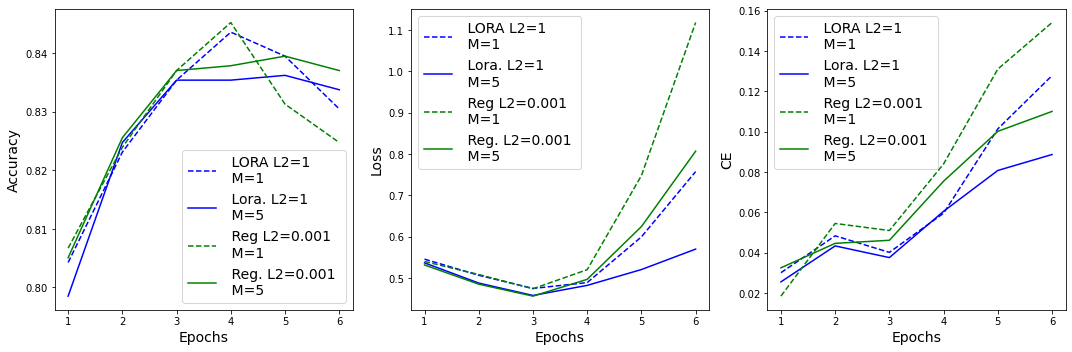

In [50]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot accuracies, losses, and ces
for name in accuracies:
    axs[0].plot(epochs_dir[name],accuracies[name], label=name, color = color_dic[name], linestyle = linestyles_dic[name])
    axs[1].plot(epochs_dir[name],losses[name], label=name, color = color_dic[name], linestyle = linestyles_dic[name])
    axs[2].plot(epochs_dir[name],ces[name], label=name, color = color_dic[name], linestyle = linestyles_dic[name])

# Set titles and labels
axs[0].set_xlabel('Epochs',fontsize=14)
axs[0].set_ylabel('Accuracy',fontsize=14)
#axs[0].set_ylim(bottom=0.4, top=0.6)

axs[1].set_xlabel('Epochs',fontsize=14)
axs[1].set_ylabel('Loss',fontsize=14)

axs[2].set_xlabel('Epochs',fontsize=14)
axs[2].set_ylabel('CE',fontsize=14)

# Add legends
axs[0].legend(fontsize=14)
axs[1].legend(fontsize=14)
axs[2].legend(fontsize=14)



# Adjust layout
plt.tight_layout()

# Show or save the plot
plt.show()
# plt.savefig('plot.png')  # Uncomment to save the plot


In [56]:
import os

# Your custom path to add
my_path = '/cephyr/users/olebal/Alvis/lora ensembles/equivariant-posteriors'

# Get the current PATH
current_path = os.environ.get('PATH')

# Add your path (use os.pathsep for cross-platform compatibility)
new_path = my_path + os.pathsep + current_path

# Set the new PATH
os.environ['PATH'] = new_path

# You can print it to verify
print(os.environ['PATH'])

/cephyr/users/olebal/Alvis/lora ensembles/equivariant-posteriors:/cephyr/users/olebal/Alvis/lora ensembles/equivariant-posteriors:/apps/Common/software/CUDAcore/11.3.1:/apps/Common/software/CUDAcore/11.3.1/nvvm/bin:/apps/Common/software/CUDAcore/11.3.1/bin:/apps/Arch/software/TensorFlow-Datasets/4.7.0-foss-2021a-CUDA-11.3.1/bin:/apps/Arch/software/tqdm/4.61.2-GCCcore-10.3.0/bin:/apps/Arch/software/AlphaFold/2.2.2-foss-2021a-CUDA-11.3.1/bin:/apps/Arch/software/Kalign/3.3.1-GCCcore-10.3.0/bin:/apps/Arch/software/HMMER/3.3.2-gompi-2021a/bin:/apps/Arch/software/HH-suite/3.3.0-gompi-2021a/scripts:/apps/Arch/software/HH-suite/3.3.0-gompi-2021a/bin:/apps/Arch/software/Perl/5.32.1-GCCcore-10.3.0/bin:/apps/Arch/software/DB/18.1.40-GCCcore-10.3.0/bin:/apps/Arch/software/TensorFlow/2.6.0-foss-2021a-CUDA-11.3.1/bin:/apps/Arch/software/LMDB/0.9.28-GCCcore-10.3.0/bin:/apps/Arch/software/ICU/69.1-GCCcore-10.3.0/sbin:/apps/Arch/software/ICU/69.1-GCCcore-10.3.0/bin:/apps/Arch/software/giflib/5.2.1-GCCc

In [251]:
#!/usr/bin/env python
from dataclasses import dataclass, field
from typing import List
import torch

from experiments.lora_ensembles.utils.generative_llm_losses import (
    generative_next_token_and_lora_l2,
    generative_next_token_loss,
    generative_single_token_and_lora_l2,
    generative_single_token_loss,
)

from lib.train_dataclasses import TrainConfig
from lib.train_dataclasses import TrainRun
from lib.train_dataclasses import TrainEval
from lib.train_dataclasses import OptimizerConfig
from lib.train_dataclasses import ComputeConfig


from lib.models.llama2_generative import LLaMA2GenerativeConfig
from lib.models.mistral_generative import MistralGenerativeConfig

from lib.metric import create_metric
from experiments.lora_ensembles.utils.lora_ens_metrics import accuracy, calibration_error
from experiments.lora_ensembles.train.lora_ens_train_config_dataclass import LoraEnsTrainConfig
from experiments.lora_ensembles.datasets.dataset_config import create_dataset_config_factory



# Configuration for Training
def create_lora_ens_train_run_config(
    ensemble_id:int,
    ens_train_config:LoraEnsTrainConfig = LoraEnsTrainConfig()
):
    create_dataset_config = create_dataset_config_factory(ens_train_config.train_dataset)
    train_config = TrainConfig(
        model_config=MistralGenerativeConfig(
            checkpoint=ens_train_config.checkpoint,
            lora_rank=ens_train_config.lora_rank,
            lora_alpha=ens_train_config.lora_alpha,
            lora_dropout=ens_train_config.lora_dropout,
            lora_l2=ens_train_config.lora_l2,
            target_modules=ens_train_config.target_modules,
        ),
        train_data_config=create_dataset_config(
            max_len_train = ens_train_config.max_len_train, 
            max_len_val = ens_train_config.max_len_val, 
            checkpoint=ens_train_config.checkpoint,
            dataset_split="train",
        ),
        val_data_config=create_dataset_config(
            max_len_train = ens_train_config.max_len_train, 
            max_len_val = ens_train_config.max_len_val, 
            checkpoint=ens_train_config.checkpoint,
            dataset_split="validation",
        ),
        loss=generative_single_token_and_lora_l2,
        optimizer=OptimizerConfig(
            optimizer=torch.optim.AdamW,
            kwargs=dict(
                weight_decay=ens_train_config.regular_l2, 
                lr=ens_train_config.learning_rate
            ),
        ),
        batch_size=ens_train_config.batch_size,
        ensemble_id=ensemble_id,
        gradient_clipping=0.3,
        _version=46,
    )
    train_eval = TrainEval(
        train_metrics=[
            create_metric(accuracy),
            create_metric(calibration_error),
            create_metric(generative_single_token_loss),
            create_metric(generative_next_token_loss),
        ],
        validation_metrics=[
            create_metric(accuracy),
            create_metric(calibration_error),
            create_metric(generative_single_token_loss),
            create_metric(generative_next_token_loss),
        ],
        data_visualizer=None,
    )
    train_run = TrainRun(
        compute_config=ComputeConfig(distributed=False, num_workers=1, num_gpus=1),
        train_config=train_config,
        train_eval=train_eval,
        epochs=ens_train_config.epochs,
        save_nth_epoch=1,
        keep_epoch_checkpoints=True,
        validate_nth_epoch=1,
    )
    return train_run


ModuleNotFoundError: No module named 'experiments'

In [ ]:
from lib.stable_hash import stable_hash



stable_hash()

In [244]:
def calculate_agreement(ens_probs_1, ens_probs_2):
    # Move tensors to the same device
    ens_probs_1 = ens_probs_1.to('cpu')
    ens_probs_2 = ens_probs_2.to('cpu')

    p1 = torch.mean(ens_probs_1, dim=0)
    p2 = torch.mean(ens_probs_2, dim=0)
    return torch.sum(torch.ones((p1.shape[0]))[torch.argmax(p1, dim=1)==torch.argmax(p2, dim=1)])/p1.shape[0]

def calculate_variance(ens_probs_1, ens_probs_2):
    # Move tensors to the same device
    ens_probs_1 = ens_probs_1.to('cpu')
    ens_probs_2 = ens_probs_2.to('cpu')

    p1 = torch.mean(ens_probs_1, dim=0)
    p2 = torch.mean(ens_probs_2, dim=0)
    return torch.sum(torch.abs(p1-p2))/(2*p1.shape[0])

In [220]:
import os

path_dir_template = "/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_evaluate/TRAIN_DS/ens/EPOCH/EVAL_DS/MEMBER_ID/"
path_files = []
names = []
members = []
epochs = []


path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append(" LORA L2=1 \n M=1, Rank=8")
color_dic[names[-1]] = "blue"
linestyles_dic[names[-1]] = "--"
members.append(["0"])
epochs.append(["1","2","3","4", "5", "6"])


path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append(" LORA L2=1 \n M=5, Rank=8")
color_dic[names[-1]] = "blue"
linestyles_dic[names[-1]] = "-"
members.append(["0", "1","2","3","4"])
epochs.append(["1","2","3","4", "5", "6"])

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_32_dr_0_rl2_0_rl2_1.dill")
names.append(" LORA L2=1 \n M=1, Rank=32")
color_dic[names[-1]] = "red"
linestyles_dic[names[-1]] = "--"
members.append(["0"])
epochs.append(["1","2","3","4", "5", "6"])

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_32_dr_0_rl2_0_rl2_1.dill")
names.append(" LORA L2=1 \n M=5, Rank=32")
color_dic[names[-1]] = "red"
linestyles_dic[names[-1]] = "-"
members.append(["0", "1","2","3","4"])
epochs.append(["1","2","3","4", "5", "6"])


In [231]:
full_res_dic = {}
epochs_dir = {}

train_dataset = "train_commonsense_qa"
eval_dataset = "dataset_mmlu_ss"



for index, path_file in enumerate(path_files):
    name = names[index]
    for epoch in epochs[index]:
        accumulated_ens_probs = []
        for member_id in members[index]:
            path_dir =  create_full_path(path_file, path_dir_template, 
                                                 epoch = epoch, member_id = member_id, 
                                                 train_dataset = train_dataset, 
                                                 eval_dataset = eval_dataset
                                                )
            full_path_file = os.path.join(path_dir, path_file)
            res = read_res_from_dill(full_path_file)
            accumulated_ens_probs.append(res['softmax_probs'].unsqueeze(0))
        targets = res['targets']
        accumulated_ens_probs = torch.cat(accumulated_ens_probs)
        add_to_dic(accumulated_ens_probs, name, full_res_dic)
        

In [232]:
names

[' LORA L2=1 \n M=1, Rank=8',
 ' LORA L2=1 \n M=5, Rank=8',
 ' LORA L2=1 \n M=1, Rank=32',
 ' LORA L2=1 \n M=5, Rank=32']

In [233]:
agreement = {}
variance = {}
epochs_dir = {}
base_model_name = names[-1]

for index, name in enumerate(names):
    name = names[index]
    for epoch in epochs[index]:
        ens_probs_1 = full_res_dic[base_model_name][int(epoch)-1]
        ens_probs_2 = full_res_dic[name][int(epoch)-1]
        add_to_dic(calculate_agreement(ens_probs_1, ens_probs_2), name, agreement)
        add_to_dic(calculate_variance(ens_probs_1, ens_probs_2), name, variance)
        add_to_dic(epoch, name, epochs_dir)
        

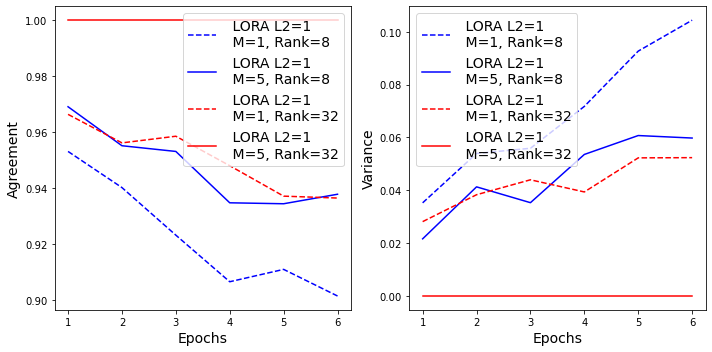

In [234]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracies, losses, and ces
for name in names:
    axs[0].plot(epochs_dir[name],agreement[name], label=name, color = color_dic[name], linestyle = linestyles_dic[name])
    axs[1].plot(epochs_dir[name],variance[name], label=name, color = color_dic[name], linestyle = linestyles_dic[name])

# Set titles and labels
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Agreement', fontsize=14)


axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Variance', fontsize=14)

# Add legends
axs[0].legend(fontsize=14)
axs[1].legend(fontsize=14)

# Adjust layout
plt.tight_layout()

# Show or save the plot
plt.show()
# plt.savefig('plot.png')  # Uncomment to save the plot
